In [137]:
import numpy as np
from scipy.signal import correlate2d
import numpy as np
from scipy.signal import fftconvolve


class Convolution:
    
    def __init__(self, input_shape, filter_size, num_filters):
        input_height, input_width = input_shape
        self.num_filters = num_filters
        self.input_shape = input_shape
        
        # Size of outputs and filters
        
        self.filter_shape = (num_filters, filter_size, filter_size) # (3,3)
        self.output_shape = (num_filters, input_height - filter_size + 1, input_width - filter_size + 1)
        
        self.filters = np.random.randn(*self.filter_shape)
        self.biases = np.random.randn(*self.output_shape)
    def forward(self, input_data):
        self.input_data = input_data
        # Initialized the input value
        output = np.zeros(self.output_shape)
        for i in range(self.num_filters):
            output[i] = correlate2d(self.input_data, self.filters[i], mode="valid")
        #Applying Relu Activtion function
        output = np.maximum(output, 0)
        return output 
    def backward(self, dL_dout, lr):
        # Create a random dL_dout array to accommodate output gradients
        h = int(self.input_data.shape[0])
        w = int(self.input_data.shape[1])   
        dL_dinput = np.zeros((h, w, self.num_filters), dtype=np.float64)
        dL_dfilters = np.zeros_like(self.filters)

        for i in range(self.num_filters):
                # Calculating the gradient of loss with respect to kernels
                dL_dfilters[i] = correlate2d(self.input_data, dL_dout[i],mode="valid")
                dL_dinput = dL_dinput.astype(np.float64)
                dL_dout[i] = dL_dout[i].astype(np.float64)
                self.filters[i] = self.filters[i]
                # Calculating the gradient of loss with respect to inputs
                dL_dinput[:,:,i] += fftconvolve(dL_dout[i].astype(np.float64), self.filters[i].astype(np.float64))

        # Updating the parameters with learning rate
        self.filters -= lr * dL_dfilters
        self.biases -= lr * dL_dout

        # returning the gradient of inputs
        return dL_dinput

In [138]:
class MaxPool:

    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, input_data):

            self.input_data = input_data
            self.num_channels, self.input_height, self.input_width = input_data.shape
            self.output_height = self.input_height // self.pool_size
            self.output_width = self.input_width // self.pool_size

            # Determining the output shape
            self.output = np.zeros((self.num_channels, self.output_height, self.output_width))

            # Iterating over different channels
            for c in range(self.num_channels):
                # Looping through the height
                for i in range(self.output_height):
                    # looping through the width
                    for j in range(self.output_width):

                        # Starting postition
                        start_i = i * self.pool_size
                        start_j = j * self.pool_size

                        # Ending Position
                        end_i = start_i + self.pool_size
                        end_j = start_j + self.pool_size

                        # Creating a patch from the input data
                        patch = input_data[c, start_i:end_i, start_j:end_j]

                        #Finding the maximum value from each patch/window
                        self.output[c, i, j] = np.max(patch)

            return self.output
    
    def backward(self, dL_dout):
        dL_dinput = np.zeros_like(self.input_data)

        for c in range(self.num_channels):
            for i in range(self.output_height):
                for j in range(self.output_width):
                    start_i = i * self.pool_size
                    start_j = j * self.pool_size

                    end_i = start_i + self.pool_size
                    end_j = start_j + self.pool_size
                    patch = self.input_data[c, start_i:end_i, start_j:end_j]

                    mask = patch == np.max(patch)

                    dL_dinput[c,start_i:end_i, start_j:end_j] = dL_dout[c, i, j] * mask

        return dL_dinput

In [139]:
class Fully_Connected:

    def __init__(self, input_size, output_size):
        self.input_size = input_size # Size of the inputs coming
        self.output_size = output_size # Size of the output producing
        self.weights = np.random.randn(output_size, self.input_size)
        self.biases = np.random.rand(output_size, 1)
    def softmax(self, z):
        # Shift the input values to avoid numerical instability
        shifted_z = z - np.max(z)
        exp_values = np.exp(shifted_z)
        sum_exp_values = np.sum(exp_values, axis=0)
        log_sum_exp = np.log(sum_exp_values)

        # Compute the softmax probabilities
        probabilities = exp_values / sum_exp_values

        return probabilities
    def softmax_derivative(self, s):
        return np.diagflat(s) - np.dot(s, s.T)
    def forward(self, input_data):
            self.input_data = input_data
            # Flattening the inputs from the previous layer into a vector
            flattened_input = input_data.flatten().reshape(1, -1)
            self.z = np.dot(self.weights, flattened_input.T) + self.biases

            # Applying Softmax
            self.output = self.softmax(self.z)
            return self.output
    def backward(self, dL_dout, lr):
            # Calculate the gradient of the loss with respect to the pre-activation (z)
            dL_dy = np.dot(self.softmax_derivative(self.output), dL_dout)
            # Calculate the gradient of the loss with respect to the weights (dw)
            dL_dw = np.dot(dL_dy, self.input_data.flatten().reshape(1, -1))

            # Calculate the gradient of the loss with respect to the biases (db)
            dL_db = dL_dy

            # Calculate the gradient of the loss with respect to the input data (dL_dinput)
            dL_dinput = np.dot(self.weights.T, dL_dy)
            dL_dinput = dL_dinput.reshape(self.input_data.shape)

            # Update the weights and biases based on the learning rate and gradients
            self.weights -= lr * dL_dw
            self.biases -= lr * dL_db

            # Return the gradient of the loss with respect to the input data
            return dL_dinput


In [140]:
def cross_entropy_loss(predictions, targets):

    num_samples = 10

    # Avoid numerical instability by adding a small epsilon value
    epsilon = 1e-7
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    loss = -np.sum(targets * np.log(predictions)) / num_samples
    return loss

def cross_entropy_loss_gradient(actual_labels, predicted_probs):
    num_samples = actual_labels.shape[0]
    gradient = -actual_labels / (predicted_probs + 1e-7) / num_samples

    return gradient


In [141]:
import pandas as pd

In [142]:
data=pd.read_csv('D:\MachineLearning\CNN\Data_skincancer\hmnist_28_28_L.csv')

In [143]:
X=data.iloc[:,0:-1].values
y=data.iloc[:,-1].values

In [144]:
from sklearn.model_selection import train_test_split

In [145]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [146]:
X_train=X_train.reshape(-1,28,28)
X_test=X_test.reshape(-1,28,28)

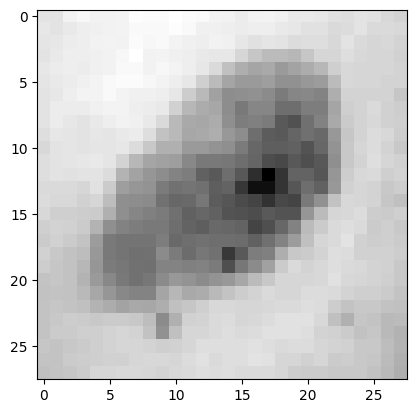

In [147]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0],cmap='gray')

In [148]:
X_train_scaled=X_train/255-0.5
X_test_scaled=X_test/255-0.5

In [149]:
conv = Convolution(X_train_scaled[0].shape, 6, 1)
pool = MaxPool(2)
full = Fully_Connected(121, 7)

def train_network(X, y, conv, pool, full, lr=0.01, epochs=200):
    for epoch in range(10):
        total_loss = 0.0
        correct_predictions = 0

        for i in range(len(X)):
            # Forward pass
            conv_out = conv.forward(X[i])
            pool_out = pool.forward(conv_out)
            full_out = full.forward(pool_out)
            loss = cross_entropy_loss(full_out.flatten(), y[i])
            total_loss += loss

            # Converting to One-Hot encoding
            one_hot_pred = np.zeros_like(full_out)
            one_hot_pred[np.argmax(full_out)] = 1
            one_hot_pred = one_hot_pred.flatten()

            num_pred = np.argmax(one_hot_pred)
            num_y = np.argmax(y[i])

            if num_pred == num_y:
                correct_predictions += 1
            # Backward pass
            gradient = cross_entropy_loss_gradient(y[i], full_out.flatten()).reshape((-1, 1))
            full_back = full.backward(gradient, lr)
            pool_back = pool.backward(full_back,)
            conv_back = conv.backward(pool_back, lr)

        # Print epoch statistics
        average_loss = total_loss / len(X)
        accuracy = correct_predictions / len(X_train) * 100.0
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f} - Accuracy: {accuracy:.2f}%")

In [150]:
def predict(input_sample, conv, pool, full):
    # Forward pass through Convolution and pooling
    conv_out = conv.forward(input_sample)
    pool_out = pool.forward(conv_out)
    # Flattening
    flattened_output = pool_out.flatten()
    # Forward pass through fully connected layer
    predictions = full.forward(flattened_output)
    return predictions

In [151]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [152]:
train_network(X_train_scaled, y_train, conv, pool, full)

Epoch 1/200 - Loss: 0.1547 - Accuracy: 60.31%
Epoch 2/200 - Loss: 0.1273 - Accuracy: 65.64%
Epoch 3/200 - Loss: 0.1197 - Accuracy: 66.79%
Epoch 4/200 - Loss: 0.1165 - Accuracy: 66.74%
Epoch 5/200 - Loss: 0.1149 - Accuracy: 66.45%
Epoch 6/200 - Loss: 0.1140 - Accuracy: 66.54%
Epoch 7/200 - Loss: 0.1135 - Accuracy: 66.59%
Epoch 8/200 - Loss: 0.1130 - Accuracy: 66.53%
Epoch 9/200 - Loss: 0.1127 - Accuracy: 66.49%
Epoch 10/200 - Loss: 0.1125 - Accuracy: 66.33%
